# Telco Customer Churn

## 1.0 Data Loading & Initial Exploration

In [ ]:
# Load the libraries

# Core libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
# Visualization
import matplotlib.pyplot as plt
import shap
# Sklearn — model selection & feature selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
# Sklearn — models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# Sklearn — metrics
from sklearn.metrics import (classification_report,
                             roc_auc_score,
                             confusion_matrix,
                             precision_recall_fscore_support,
                             roc_curve,
                             auc)

from sklearn.calibration import calibration_curve
# Imbalanced-learn (resampling)
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import TomekLinks

In [2]:
# Load the data
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [3]:
# Preview the data
print("First 5 rows:")
df.head()

First 5 rows:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# Check dataset shape
print("\nDataset shape:", df.shape)


Dataset shape: (7043, 21)


In [5]:
# Check data types
print("\nData types:")
print(df.dtypes)


Data types:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


## 2.0 Data Cleaning

### 2.1 Handling Missing Values

In [6]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [7]:
# Check target variable distribution
print("\nChurn value counts:")
print(df['Churn'].value_counts())


Churn value counts:
Churn
No     5174
Yes    1869
Name: count, dtype: int64


In [8]:
# Check why TotalCharges is object
print("Unique problematic values in TotalCharges:")
print(df.loc[df['TotalCharges'].str.strip() == '', 'TotalCharges'])

Unique problematic values in TotalCharges:
488      
753      
936      
1082     
1340     
3331     
3826     
4380     
5218     
6670     
6754     
Name: TotalCharges, dtype: object


## 3.0 Feature Engineering & Encoding

### 3.1 Data Conversion

In [9]:
# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check how many NaNs appeared after conversion
print("\nMissing TotalCharges after conversion:", df['TotalCharges'].isnull().sum())

# Drop rows with missing TotalCharges
df = df.dropna(subset=['TotalCharges'])
print("Shape after dropping missing TotalCharges:", df.shape)


Missing TotalCharges after conversion: 11
Shape after dropping missing TotalCharges: (7032, 21)


### 3.2 Drop Irrelevant Feature

In [10]:
# Drop customerID — not useful for modeling
df = df.drop(columns=['customerID'])

In [11]:
# Sanity check categorical values
for col in df.select_dtypes(include='object').columns:
    print(f"Unique values in {col}: {df[col].unique()}")

# Strip whitespaces and standardize category names if needed
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

Unique values in gender: ['Female' 'Male']
Unique values in Partner: ['Yes' 'No']
Unique values in Dependents: ['No' 'Yes']
Unique values in PhoneService: ['No' 'Yes']
Unique values in MultipleLines: ['No phone service' 'No' 'Yes']
Unique values in InternetService: ['DSL' 'Fiber optic' 'No']
Unique values in OnlineSecurity: ['No' 'Yes' 'No internet service']
Unique values in OnlineBackup: ['Yes' 'No' 'No internet service']
Unique values in DeviceProtection: ['No' 'Yes' 'No internet service']
Unique values in TechSupport: ['No' 'Yes' 'No internet service']
Unique values in StreamingTV: ['No' 'Yes' 'No internet service']
Unique values in StreamingMovies: ['No' 'Yes' 'No internet service']
Unique values in Contract: ['Month-to-month' 'One year' 'Two year']
Unique values in PaperlessBilling: ['Yes' 'No']
Unique values in PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Unique values in Churn: ['No' 'Yes']


In [12]:
# Final check
print("\nData types after cleaning:")
print(df.dtypes)


Data types after cleaning:
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object


In [13]:
# Create Tenure Group
def tenure_group(tenure):
    if tenure <= 12:
        return '0-1 year'
    elif tenure <= 24:
        return '1-2 years'
    elif tenure <= 48:
        return '2-4 years'
    elif tenure <= 60:
        return '4-5 years'
    else:
        return '5+ years'

df['TenureGroup'] = df['tenure'].apply(tenure_group)

# Simplify categorical features
# Convert 'No internet service' and 'No phone service' to 'No' for simplicity
service_cols = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup',
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for col in service_cols:
    df[col] = df[col].replace({'No internet service': 'No', 'No phone service': 'No'})

# Check updated category levels
for col in service_cols + ['TenureGroup']:
    print(f"Unique values in {col}: {df[col].unique()}")

# Drop original 'tenure' since we now have TenureGroup
df.drop(columns=['tenure'], inplace=True)

Unique values in MultipleLines: ['No' 'Yes']
Unique values in OnlineSecurity: ['No' 'Yes']
Unique values in OnlineBackup: ['Yes' 'No']
Unique values in DeviceProtection: ['No' 'Yes']
Unique values in TechSupport: ['No' 'Yes']
Unique values in StreamingTV: ['No' 'Yes']
Unique values in StreamingMovies: ['No' 'Yes']
Unique values in TenureGroup: ['0-1 year' '2-4 years' '1-2 years' '5+ years' '4-5 years']


### 3.3 One-Hot Encoding

In [14]:
# Encode target variable
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, drop_first=True) 

print("Shape after encoding:", df_encoded.shape)

Shape after encoding: (7032, 27)


## 4.0 Stratified Train-Test Split

In [15]:
# Define features (X) and target (y)
X = df_encoded.drop(columns=['Churn'])
y = df_encoded['Churn']

# Stratified train-test split (preserve churn proportion)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [16]:
# Sanity checks
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Churn rate in training set:", y_train.mean())
print("Churn rate in test set:", y_test.mean())

Training set shape: (5625, 26)
Test set shape: (1407, 26)
Churn rate in training set: 0.2657777777777778
Churn rate in test set: 0.2658137882018479


## 5.0 Baseline Model Training

### 5.1 Logistic Regression (Baseline)

In [17]:
# Initialize and train Logistic Regression
baseline_lr = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
baseline_lr.fit(X_train, y_train)

# Predictions
y_pred_lr = baseline_lr.predict(X_test)
y_proba_lr = baseline_lr.predict_proba(X_test)[:, 1]

# Evaluation
print("===== Logistic Regression (Baseline) =====")
print(classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

===== Logistic Regression (Baseline) =====
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1033
           1       0.65      0.52      0.58       374

    accuracy                           0.80      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407

ROC AUC: 0.83180316921277
Confusion Matrix:
 [[930 103]
 [181 193]]


### 5.2 Random Forest (Baseline)

In [18]:
# Initialize and train Random Forest
baseline_rf = RandomForestClassifier(random_state=42)
baseline_rf.fit(X_train, y_train)

# Predictions
y_pred_rf = baseline_rf.predict(X_test)
y_proba_rf = baseline_rf.predict_proba(X_test)[:, 1]

# Evaluation
print("\n===== Random Forest (Baseline) =====")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


===== Random Forest (Baseline) =====
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.61      0.49      0.55       374

    accuracy                           0.78      1407
   macro avg       0.72      0.69      0.70      1407
weighted avg       0.77      0.78      0.77      1407

ROC AUC: 0.8133001330427445
Confusion Matrix:
 [[917 116]
 [190 184]]


## 6.0 Handling Class Imbalance

### 6.1 ADASYN Oversampling

In [19]:
# Initialize ADASYN
adasyn = ADASYN(random_state=42)

# Fit and resample
X_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X_train, y_train)

# Check new class distribution
print("ADASYN resampled class distribution:")
print(pd.Series(y_resampled_adasyn).value_counts())

ADASYN resampled class distribution:
Churn
1    4194
0    4130
Name: count, dtype: int64


### 6.2 Tomek Links Undersampling

In [20]:
# Initialize Tomek Links
tomek = TomekLinks()

# Apply Tomek Links *directly* to the original training set
X_resampled_tomek, y_resampled_tomek = tomek.fit_resample(X_train, y_train)

# Check new class distribution
print("Tomek Links resampled class distribution:")
print(pd.Series(y_resampled_tomek).value_counts())

Tomek Links resampled class distribution:
Churn
0    3680
1    1495
Name: count, dtype: int64


### 6.3 ADASYN + Tomek Links Resampling Approach

In [21]:
# Apply ADASYN first
X_resampled_hybrid, y_resampled_hybrid = adasyn.fit_resample(X_train, y_train)

# Apply Tomek Links *to the ADASYN-resampled data*
X_resampled_hybrid_final, y_resampled_hybrid_final = tomek.fit_resample(
    X_resampled_hybrid, y_resampled_hybrid)

# Check new class distribution
print("ADASYN + Tomek Links hybrid resampled class distribution:")
print(pd.Series(y_resampled_hybrid_final).value_counts())

ADASYN + Tomek Links hybrid resampled class distribution:
Churn
0    4130
1    3765
Name: count, dtype: int64


In [22]:
def train_and_evaluate_model(model, X_train_resampled, y_train_resampled, X_test, y_test, model_name):
    # Train
    model.fit(X_train_resampled, y_train_resampled)

    # Predict
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Evaluation
    print(f"\n===== {model_name} =====")
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

### 6.4 Model Evaluation

#### 6.4.1 Logistic Regression (ADASYN | Tomek Links | Hybrid)

In [23]:
# Initialize Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

# ADASYN
train_and_evaluate_model(lr, X_resampled_adasyn, y_resampled_adasyn, X_test, y_test, "Logistic Regression (ADASYN)")

# Tomek Links
train_and_evaluate_model(lr, X_resampled_tomek, y_resampled_tomek, X_test, y_test, "Logistic Regression (Tomek Links)")

# Hybrid
train_and_evaluate_model(lr, X_resampled_hybrid_final, y_resampled_hybrid_final, X_test, y_test, "Logistic Regression (ADASYN + Tomek)")


===== Logistic Regression (ADASYN) =====
              precision    recall  f1-score   support

           0       0.85      0.80      0.82      1033
           1       0.52      0.61      0.57       374

    accuracy                           0.75      1407
   macro avg       0.69      0.71      0.69      1407
weighted avg       0.76      0.75      0.75      1407

ROC AUC: 0.7829914945825202
Confusion Matrix:
 [[823 210]
 [144 230]]

===== Logistic Regression (Tomek Links) =====
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1033
           1       0.61      0.61      0.61       374

    accuracy                           0.79      1407
   macro avg       0.74      0.74      0.74      1407
weighted avg       0.79      0.79      0.79      1407

ROC AUC: 0.8304727417676566
Confusion Matrix:
 [[888 145]
 [145 229]]

===== Logistic Regression (ADASYN + Tomek) =====
              precision    recall  f1-score   support

           0

#### 6.4.2 Random Forest (ADASYN | Tomek Links | Hybrid)

In [24]:
# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

# ADASYN
train_and_evaluate_model(rf, X_resampled_adasyn, y_resampled_adasyn, X_test, y_test, "Random Forest (ADASYN)")

# Tomek Links
train_and_evaluate_model(rf, X_resampled_tomek, y_resampled_tomek, X_test, y_test, "Random Forest (Tomek Links)")

# Hybrid
train_and_evaluate_model(rf, X_resampled_hybrid_final, y_resampled_hybrid_final, X_test, y_test, "Random Forest (ADASYN + Tomek)")


===== Random Forest (ADASYN) =====
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1033
           1       0.56      0.59      0.57       374

    accuracy                           0.77      1407
   macro avg       0.70      0.71      0.71      1407
weighted avg       0.77      0.77      0.77      1407

ROC AUC: 0.8072950908780303
Confusion Matrix:
 [[856 177]
 [153 221]]

===== Random Forest (Tomek Links) =====
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1033
           1       0.59      0.60      0.60       374

    accuracy                           0.78      1407
   macro avg       0.72      0.72      0.72      1407
weighted avg       0.78      0.78      0.78      1407

ROC AUC: 0.8200130972040317
Confusion Matrix:
 [[881 152]
 [151 223]]

===== Random Forest (ADASYN + Tomek) =====
              precision    recall  f1-score   support

           0       0.84      0

## 7.0 Recursive Feature Elimination (RFE)

In [25]:
def perform_rfe(X, y, n_features):
    # Create a Logistic Regression model (solver liblinear for small datasets)
    model = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

    # Recursive Feature Elimination
    rfe = RFE(model, n_features_to_select=n_features)
    rfe.fit(X, y)

    # Get selected feature names
    selected_features = X.columns[rfe.support_].tolist()
    return selected_features

In [26]:
# Let's select 10 features to keep things simple and prevent overfitting
n_features = 10

In [27]:
# ADASYN
features_adasyn = perform_rfe(X_resampled_adasyn, y_resampled_adasyn, n_features)
print("\nSelected features for ADASYN:", features_adasyn)

# Tomek Links
features_tomek = perform_rfe(X_resampled_tomek, y_resampled_tomek, n_features)
print("\nSelected features for Tomek Links:", features_tomek)

# ADASYN + Tomek Hybrid
features_hybrid = perform_rfe(X_resampled_hybrid_final, y_resampled_hybrid_final, n_features)
print("\nSelected features for ADASYN + Tomek Links hybrid:", features_hybrid)


Selected features for ADASYN: ['gender_Male', 'InternetService_Fiber optic', 'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'TenureGroup_5+ years']

Selected features for Tomek Links: ['InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_Yes', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Electronic check', 'TenureGroup_1-2 years', 'TenureGroup_2-4 years', 'TenureGroup_4-5 years', 'TenureGroup_5+ years']

Selected features for ADASYN + Tomek Links hybrid: ['gender_Male', 'InternetService_Fiber optic', 'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'TenureGroup_5+ years']


In [28]:
# Subset for ADASYN
X_adasyn_rfe = X_resampled_adasyn[features_adasyn]

# Subset for Tomek Links
X_tomek_rfe = X_resampled_tomek[features_tomek]

# Subset for ADASYN + Tomek Hybrid
X_hybrid_rfe = X_resampled_hybrid_final[features_hybrid]

# Also subset the test set for fair comparison
X_test_adasyn = X_test[features_adasyn]
X_test_tomek = X_test[features_tomek]
X_test_hybrid = X_test[features_hybrid]

In [29]:
def train_and_evaluate_model(model, X_train_resampled, y_train_resampled, X_test, y_test, model_name):
    model.fit(X_train_resampled, y_train_resampled)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n===== {model_name} =====")
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

### 7.1 Model Evaluation

#### 7.1.1 Logistic Regression (ADASYN + RFE | Tomek + RFE | Hybrid + RFE)

In [30]:
# Logistic Regression model
lr = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

# ADASYN
train_and_evaluate_model(lr, X_adasyn_rfe, y_resampled_adasyn, X_test_adasyn, y_test, "Logistic Regression (ADASYN + RFE)")

# Tomek
train_and_evaluate_model(lr, X_tomek_rfe, y_resampled_tomek, X_test_tomek, y_test, "Logistic Regression (Tomek + RFE)")

# Hybrid
train_and_evaluate_model(lr, X_hybrid_rfe, y_resampled_hybrid_final, X_test_hybrid, y_test, "Logistic Regression (Hybrid + RFE)")


===== Logistic Regression (ADASYN + RFE) =====
              precision    recall  f1-score   support

           0       0.85      0.72      0.78      1033
           1       0.46      0.66      0.54       374

    accuracy                           0.71      1407
   macro avg       0.66      0.69      0.66      1407
weighted avg       0.75      0.71      0.72      1407

ROC AUC: 0.7665902231701446
Confusion Matrix:
 [[748 285]
 [129 245]]

===== Logistic Regression (Tomek + RFE) =====
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1033
           1       0.59      0.59      0.59       374

    accuracy                           0.78      1407
   macro avg       0.72      0.72      0.72      1407
weighted avg       0.78      0.78      0.78      1407

ROC AUC: 0.8270094890019722
Confusion Matrix:
 [[882 151]
 [153 221]]

===== Logistic Regression (Hybrid + RFE) =====
              precision    recall  f1-score   support

        

#### 7.1.2 Random Forest (ADASYN + RFE | Tomek + RFE | Hybrid + RFE)

In [31]:
# Random Forest model
rf = RandomForestClassifier(random_state=42)

# ADASYN
train_and_evaluate_model(rf, X_adasyn_rfe, y_resampled_adasyn, X_test_adasyn, y_test, "Random Forest (ADASYN + RFE)")

# Tomek
train_and_evaluate_model(rf, X_tomek_rfe, y_resampled_tomek, X_test_tomek, y_test, "Random Forest (Tomek + RFE)")

# Hybrid
train_and_evaluate_model(rf, X_hybrid_rfe, y_resampled_hybrid_final, X_test_hybrid, y_test, "Random Forest (Hybrid + RFE)")


===== Random Forest (ADASYN + RFE) =====
              precision    recall  f1-score   support

           0       0.86      0.74      0.79      1033
           1       0.48      0.66      0.56       374

    accuracy                           0.72      1407
   macro avg       0.67      0.70      0.68      1407
weighted avg       0.76      0.72      0.73      1407

ROC AUC: 0.7754308358915158
Confusion Matrix:
 [[765 268]
 [127 247]]

===== Random Forest (Tomek + RFE) =====
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1033
           1       0.61      0.54      0.57       374

    accuracy                           0.78      1407
   macro avg       0.72      0.71      0.71      1407
weighted avg       0.78      0.78      0.78      1407

ROC AUC: 0.819914738754782
Confusion Matrix:
 [[903 130]
 [173 201]]

===== Random Forest (Hybrid + RFE) =====
              precision    recall  f1-score   support

           0       0.86    

## 8.0 Hyperparameter Tuning

### 8.1 GridSearchCV for Logistic Regression

In [32]:
# Define parameter grid
lr_param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear']
}

# Initialize model
lr = LogisticRegression(max_iter=1000, random_state=42)

# Tomek + RFE
grid_lr_tomek = GridSearchCV(lr, lr_param_grid, scoring='f1', cv=5)
grid_lr_tomek.fit(X_tomek_rfe, y_resampled_tomek)

print("Best LR params (Tomek):", grid_lr_tomek.best_params_)

# ADASYN + RFE
grid_lr_adasyn = GridSearchCV(lr, lr_param_grid, scoring='f1', cv=5)
grid_lr_adasyn.fit(X_adasyn_rfe, y_resampled_adasyn)

print("Best LR params (ADASYN):", grid_lr_adasyn.best_params_)

Best LR params (Tomek): {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best LR params (ADASYN): {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


### 8.2 GridSearchCV for Random Forest

In [33]:
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)

# Tomek + RFE
grid_rf_tomek = GridSearchCV(rf, rf_param_grid, scoring='f1', cv=5)
grid_rf_tomek.fit(X_tomek_rfe, y_resampled_tomek)

print("Best RF params (Tomek):", grid_rf_tomek.best_params_)

# ADASYN + RFE
grid_rf_adasyn = GridSearchCV(rf, rf_param_grid, scoring='f1', cv=5)
grid_rf_adasyn.fit(X_adasyn_rfe, y_resampled_adasyn)

print("Best RF params (ADASYN):", grid_rf_adasyn.best_params_)

Best RF params (Tomek): {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best RF params (ADASYN): {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


### 8.3 Model Evaluation 

#### 8.3.1 Logistic Regression (Tomek + RFE + Tuned | ADASYN + RFE + Tuned)

In [34]:
# Logistic Regression with Tomek
lr_tomek = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', max_iter=1000, random_state=42)
train_and_evaluate_model(lr_tomek, X_tomek_rfe, y_resampled_tomek, X_test_tomek, y_test, "Logistic Regression (Tomek + RFE + Tuned)")

# Logistic Regression with ADASYN
lr_adasyn = LogisticRegression(C=0.01, penalty='l2', solver='liblinear', max_iter=1000, random_state=42)
train_and_evaluate_model(lr_adasyn, X_adasyn_rfe, y_resampled_adasyn, X_test_adasyn, y_test, "Logistic Regression (ADASYN + RFE + Tuned)")


===== Logistic Regression (Tomek + RFE + Tuned) =====
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1033
           1       0.60      0.59      0.59       374

    accuracy                           0.79      1407
   macro avg       0.72      0.72      0.72      1407
weighted avg       0.78      0.79      0.78      1407

ROC AUC: 0.825956018242904
Confusion Matrix:
 [[884 149]
 [153 221]]

===== Logistic Regression (ADASYN + RFE + Tuned) =====
              precision    recall  f1-score   support

           0       0.87      0.69      0.77      1033
           1       0.46      0.71      0.55       374

    accuracy                           0.70      1407
   macro avg       0.66      0.70      0.66      1407
weighted avg       0.76      0.70      0.71      1407

ROC AUC: 0.7852291493029492
Confusion Matrix:
 [[717 316]
 [110 264]]


#### 8.3.2 Random Forest (Tomek + RFE + Tuned | ADASYN + RFE + Tuned)

In [35]:
# Random Forest with Tomek
rf_tomek = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=2,
    random_state=42
)
train_and_evaluate_model(rf_tomek, X_tomek_rfe, y_resampled_tomek, X_test_tomek, y_test, "Random Forest (Tomek + RFE + Tuned)")

# Random Forest with ADASYN
rf_adasyn = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=5,
    random_state=42
)
train_and_evaluate_model(rf_adasyn, X_adasyn_rfe, y_resampled_adasyn, X_test_adasyn, y_test, "Random Forest (ADASYN + RFE + Tuned)")


===== Random Forest (Tomek + RFE + Tuned) =====
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1033
           1       0.61      0.53      0.57       374

    accuracy                           0.79      1407
   macro avg       0.73      0.71      0.71      1407
weighted avg       0.78      0.79      0.78      1407

ROC AUC: 0.822491471287098
Confusion Matrix:
 [[907 126]
 [174 200]]

===== Random Forest (ADASYN + RFE + Tuned) =====
              precision    recall  f1-score   support

           0       0.86      0.74      0.80      1033
           1       0.48      0.66      0.56       374

    accuracy                           0.72      1407
   macro avg       0.67      0.70      0.68      1407
weighted avg       0.76      0.72      0.73      1407

ROC AUC: 0.7781266339150286
Confusion Matrix:
 [[766 267]
 [127 247]]


## 9.0 Final Model Evaluation

### 9.1 Threshold Tuning

#### 9.1.1 Logistic Regression

In [36]:
# Predict probabilities
y_proba_lr_tomek = lr_tomek.predict_proba(X_test_tomek)[:, 1]

# Define thresholds to test
thresholds = np.arange(0.3, 0.71, 0.01)

print("Threshold | Precision | Recall | F1")
for thresh in thresholds:
    y_pred_thresh = (y_proba_lr_tomek >= thresh).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_thresh, average='binary')
    print(f"{thresh:.2f} | {precision:.2f} | {recall:.2f} | {f1:.2f}")

Threshold | Precision | Recall | F1
0.30 | 0.47 | 0.81 | 0.60
0.31 | 0.48 | 0.80 | 0.60
0.32 | 0.49 | 0.78 | 0.60
0.33 | 0.52 | 0.77 | 0.62
0.34 | 0.52 | 0.77 | 0.62
0.35 | 0.52 | 0.77 | 0.62
0.36 | 0.52 | 0.76 | 0.62
0.37 | 0.52 | 0.76 | 0.62
0.38 | 0.52 | 0.76 | 0.62
0.39 | 0.52 | 0.76 | 0.62
0.40 | 0.53 | 0.75 | 0.62
0.41 | 0.53 | 0.74 | 0.62
0.42 | 0.53 | 0.74 | 0.62
0.43 | 0.53 | 0.72 | 0.61
0.44 | 0.55 | 0.68 | 0.61
0.45 | 0.55 | 0.68 | 0.61
0.46 | 0.59 | 0.59 | 0.59
0.47 | 0.59 | 0.59 | 0.59
0.48 | 0.60 | 0.59 | 0.59
0.49 | 0.60 | 0.59 | 0.59
0.50 | 0.60 | 0.59 | 0.59
0.51 | 0.60 | 0.59 | 0.59
0.52 | 0.60 | 0.59 | 0.59
0.53 | 0.60 | 0.58 | 0.59
0.54 | 0.62 | 0.54 | 0.58
0.55 | 0.62 | 0.54 | 0.58
0.56 | 0.64 | 0.45 | 0.53
0.57 | 0.66 | 0.40 | 0.50
0.58 | 0.66 | 0.39 | 0.49
0.59 | 0.66 | 0.39 | 0.49
0.60 | 0.66 | 0.39 | 0.49
0.61 | 0.66 | 0.39 | 0.49
0.62 | 0.66 | 0.39 | 0.49
0.63 | 0.66 | 0.39 | 0.49
0.64 | 0.66 | 0.39 | 0.49
0.65 | 0.66 | 0.39 | 0.49
0.66 | 0.68 | 0.32 | 0.44
0.

#### 9.1.2 Random Forest

In [37]:
y_proba_rf_adasyn = rf_adasyn.predict_proba(X_test_adasyn)[:, 1]

print("\nThreshold | Precision | Recall | F1")
for thresh in thresholds:
    y_pred_thresh = (y_proba_rf_adasyn >= thresh).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_thresh, average='binary')
    print(f"{thresh:.2f} | {precision:.2f} | {recall:.2f} | {f1:.2f}")


Threshold | Precision | Recall | F1
0.30 | 0.40 | 0.86 | 0.55
0.31 | 0.40 | 0.86 | 0.55
0.32 | 0.40 | 0.86 | 0.55
0.33 | 0.41 | 0.84 | 0.55
0.34 | 0.43 | 0.82 | 0.56
0.35 | 0.43 | 0.82 | 0.57
0.36 | 0.43 | 0.82 | 0.57
0.37 | 0.43 | 0.82 | 0.57
0.38 | 0.44 | 0.82 | 0.57
0.39 | 0.44 | 0.82 | 0.57
0.40 | 0.44 | 0.81 | 0.57
0.41 | 0.44 | 0.78 | 0.56
0.42 | 0.44 | 0.78 | 0.56
0.43 | 0.44 | 0.73 | 0.55
0.44 | 0.44 | 0.73 | 0.55
0.45 | 0.44 | 0.73 | 0.55
0.46 | 0.45 | 0.70 | 0.55
0.47 | 0.45 | 0.69 | 0.55
0.48 | 0.47 | 0.67 | 0.55
0.49 | 0.48 | 0.66 | 0.56
0.50 | 0.48 | 0.66 | 0.56
0.51 | 0.48 | 0.65 | 0.55
0.52 | 0.48 | 0.65 | 0.55
0.53 | 0.48 | 0.65 | 0.55
0.54 | 0.49 | 0.65 | 0.56
0.55 | 0.49 | 0.65 | 0.56
0.56 | 0.49 | 0.62 | 0.55
0.57 | 0.50 | 0.61 | 0.55
0.58 | 0.50 | 0.58 | 0.54
0.59 | 0.50 | 0.56 | 0.53
0.60 | 0.50 | 0.54 | 0.52
0.61 | 0.51 | 0.53 | 0.52
0.62 | 0.55 | 0.48 | 0.51
0.63 | 0.55 | 0.48 | 0.51
0.64 | 0.57 | 0.48 | 0.52
0.65 | 0.57 | 0.46 | 0.51
0.66 | 0.57 | 0.44 | 0.50
0

In [38]:
# Logistic Regression - Tomek
lr_tomek = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', max_iter=1000, random_state=42)
lr_tomek.fit(X_tomek_rfe, y_resampled_tomek)

# Random Forest - ADASYN
rf_adasyn = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=5,
    random_state=42
)
rf_adasyn.fit(X_adasyn_rfe, y_resampled_adasyn)

RandomForestClassifier(min_samples_split=5, random_state=42)

### 9.2 Model Evaluation

In [39]:
def evaluate_with_threshold_full_report(model, X_test, y_test, threshold, model_name):
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    print(f"\n===== {model_name} =====")
    print("Threshold:", threshold)
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 3))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

In [40]:
# Logistic Regression - Tomek (Threshold 0.34)
evaluate_with_threshold_full_report(lr_tomek, X_test_tomek, y_test, 0.34, "Logistic Regression (Tomek + RFE + Tuned)")

# Random Forest - ADASYN (Threshold 0.35)
evaluate_with_threshold_full_report(rf_adasyn, X_test_adasyn, y_test, 0.35, "Random Forest (ADASYN + RFE + Tuned)")


===== Logistic Regression (Tomek + RFE + Tuned) =====
Threshold: 0.34
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1033
           1       0.52      0.77      0.62       374

    accuracy                           0.75      1407
   macro avg       0.71      0.76      0.72      1407
weighted avg       0.80      0.75      0.76      1407

ROC AUC: 0.826
Confusion Matrix:
 [[764 269]
 [ 85 289]]

===== Random Forest (ADASYN + RFE + Tuned) =====
Threshold: 0.35
              precision    recall  f1-score   support

           0       0.91      0.61      0.73      1033
           1       0.43      0.82      0.57       374

    accuracy                           0.67      1407
   macro avg       0.67      0.72      0.65      1407
weighted avg       0.78      0.67      0.69      1407

ROC AUC: 0.778
Confusion Matrix:
 [[629 404]
 [ 66 308]]


## 10.0 Model Explainability

In [41]:
# Baseline models already exist: baseline_lr, baseline_rf

# Logistic Regression models 

lr_adasyn_model = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
lr_adasyn_model.fit(X_resampled_adasyn, y_resampled_adasyn)

lr_tomek_model = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
lr_tomek_model.fit(X_resampled_tomek, y_resampled_tomek)

lr_hybrid_model = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
lr_hybrid_model.fit(X_resampled_hybrid_final, y_resampled_hybrid_final)

# Logistic Regression RFE models
lr_adasyn_rfe_model = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
lr_adasyn_rfe_model.fit(X_adasyn_rfe, y_resampled_adasyn)

lr_tomek_rfe_model = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
lr_tomek_rfe_model.fit(X_tomek_rfe, y_resampled_tomek)

lr_hybrid_rfe_model = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
lr_hybrid_rfe_model.fit(X_hybrid_rfe, y_resampled_hybrid_final)

# Tuned models (already fitted earlier)
# lr_tomek
# lr_adasyn

# Random Forest models

rf_adasyn_model = RandomForestClassifier(random_state=42)
rf_adasyn_model.fit(X_resampled_adasyn, y_resampled_adasyn)

rf_tomek_model = RandomForestClassifier(random_state=42)
rf_tomek_model.fit(X_resampled_tomek, y_resampled_tomek)

rf_hybrid_model = RandomForestClassifier(random_state=42)
rf_hybrid_model.fit(X_resampled_hybrid_final, y_resampled_hybrid_final)

# Random Forest RFE models
rf_adasyn_rfe_model = RandomForestClassifier(random_state=42)
rf_adasyn_rfe_model.fit(X_adasyn_rfe, y_resampled_adasyn)

rf_tomek_rfe_model = RandomForestClassifier(random_state=42)
rf_tomek_rfe_model.fit(X_tomek_rfe, y_resampled_tomek)

rf_hybrid_rfe_model = RandomForestClassifier(random_state=42)
rf_hybrid_rfe_model.fit(X_hybrid_rfe, y_resampled_hybrid_final)

# Tuned models (already fitted earlier):
# rf_tomek
# rf_adasyn

RandomForestClassifier(random_state=42)

### 10.1 Creating Models Dictionary

In [42]:
# Baseline models
y_proba_lr_baseline = baseline_lr.predict_proba(X_test)[:, 1]
y_proba_rf_baseline = baseline_rf.predict_proba(X_test)[:, 1]

# Logistic Regression models (trained on FULL features)
y_proba_lr_adasyn = lr_adasyn_model.predict_proba(X_test)[:, 1]
y_proba_lr_tomek = lr_tomek_model.predict_proba(X_test)[:, 1]
y_proba_lr_hybrid = lr_hybrid_model.predict_proba(X_test)[:, 1]

# Random Forest models (trained on FULL features)
y_proba_rf_adasyn = rf_adasyn_model.predict_proba(X_test)[:, 1]
y_proba_rf_tomek = rf_tomek_model.predict_proba(X_test)[:, 1]
y_proba_rf_hybrid = rf_hybrid_model.predict_proba(X_test)[:, 1]

# Logistic Regression RFE models (trained on reduced features)
y_proba_lr_adasyn_rfe = lr_adasyn_rfe_model.predict_proba(X_test_adasyn)[:, 1]
y_proba_lr_tomek_rfe = lr_tomek_rfe_model.predict_proba(X_test_tomek)[:, 1]
y_proba_lr_hybrid_rfe = lr_hybrid_rfe_model.predict_proba(X_test_hybrid)[:, 1]

# Random Forest RFE models (trained on reduced features)
y_proba_rf_adasyn_rfe = rf_adasyn_rfe_model.predict_proba(X_test_adasyn)[:, 1]
y_proba_rf_tomek_rfe = rf_tomek_rfe_model.predict_proba(X_test_tomek)[:, 1]
y_proba_rf_hybrid_rfe = rf_hybrid_rfe_model.predict_proba(X_test_hybrid)[:, 1]

# Tuned Logistic Regression models
y_proba_lr_tomek_rfe_tuned = lr_tomek.predict_proba(X_test_tomek)[:, 1]
y_proba_lr_adasyn_rfe_tuned = lr_adasyn.predict_proba(X_test_adasyn)[:, 1]

# Tuned Random Forest models
y_proba_rf_tomek_rfe_tuned = rf_tomek.predict_proba(X_test_tomek)[:, 1]
y_proba_rf_adasyn_rfe_tuned = rf_adasyn.predict_proba(X_test_adasyn)[:, 1]

# Logistic Regression models 
model_probs_lr = {
    "Logistic Regression (Baseline)": y_proba_lr_baseline,
    "Logistic Regression (ADASYN)": y_proba_lr_adasyn,
    "Logistic Regression (Tomek Links)": y_proba_lr_tomek,
    "Logistic Regression (ADASYN + Tomek)": y_proba_lr_hybrid,
    "Logistic Regression (ADASYN + RFE)": y_proba_lr_adasyn_rfe,
    "Logistic Regression (Tomek + RFE)": y_proba_lr_tomek_rfe,
    "Logistic Regression (Hybrid + RFE)": y_proba_lr_hybrid_rfe,
    "Logistic Regression (Tomek + RFE + Tuned)": y_proba_lr_tomek_rfe_tuned,
    "Logistic Regression (ADASYN + RFE + Tuned)": y_proba_lr_adasyn_rfe_tuned
}

# Random Forest models 
model_probs_rf = {
    "Random Forest (Baseline)": y_proba_rf_baseline,
    "Random Forest (ADASYN)": y_proba_rf_adasyn,
    "Random Forest (Tomek Links)": y_proba_rf_tomek,
    "Random Forest (ADASYN + Tomek)": y_proba_rf_hybrid,
    "Random Forest (ADASYN + RFE)": y_proba_rf_adasyn_rfe,
    "Random Forest (Tomek + RFE)": y_proba_rf_tomek_rfe,
    "Random Forest (Hybrid + RFE)": y_proba_rf_hybrid_rfe,
    "Random Forest (Tomek + RFE + Tuned)": y_proba_rf_tomek_rfe_tuned,
    "Random Forest (ADASYN + RFE + Tuned)": y_proba_rf_adasyn_rfe_tuned
}

### 10.2 SHAP Explainers for Logistic Regression Models

In [43]:
def plot_precision_recall_vs_threshold(model_probs, y_test, title):
    plt.figure(figsize=(14, 8))
    thresholds = np.arange(0.1, 0.9, 0.02)

    colors = plt.get_cmap('tab20').colors
    color_idx = 0

    for model_name, y_proba in model_probs.items():
        precisions = []
        recalls = []
        for t in thresholds:
            y_pred = (y_proba >= t).astype(int)
            precision, recall, _, _ = precision_recall_fscore_support(
                y_test, y_pred, average='binary', zero_division=0)
            precisions.append(precision)
            recalls.append(recall)

        color = colors[color_idx % len(colors)]  # Cycle through colors

        # Plot precision (solid line)
        plt.plot(thresholds, precisions, linestyle='-', color=color, linewidth=2, label=f'{model_name} Precision')

        # Plot recall (dashed line with the same color but lighter)
        plt.plot(thresholds, recalls, linestyle='--', color=color, linewidth=1.5, label=f'{model_name} Recall')

        color_idx += 1

    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title(f'Precision and Recall vs Threshold — {title}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

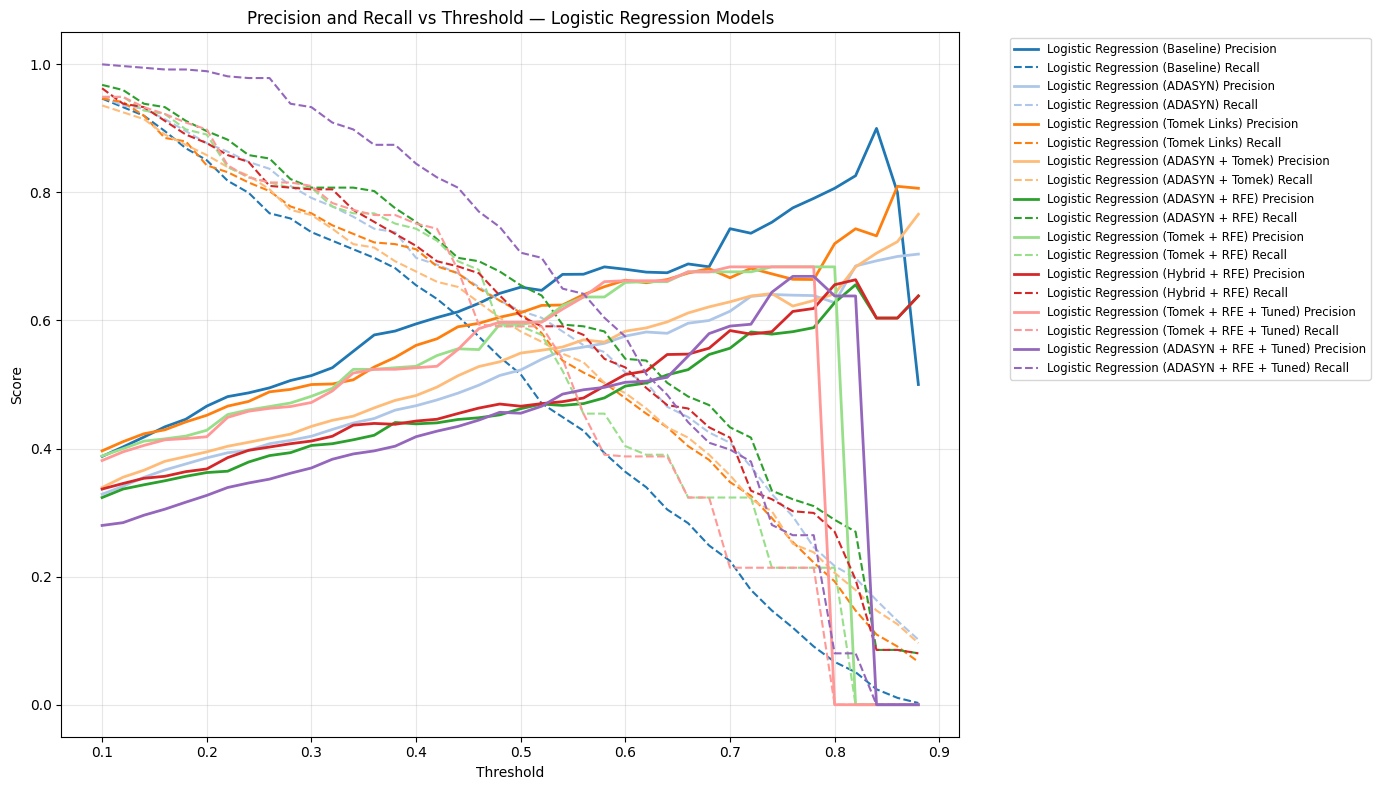

In [44]:
plot_precision_recall_vs_threshold(model_probs_lr, y_test, "Logistic Regression Models")

In [45]:
thresholds = np.arange(0.1, 0.9, 0.02)
proba = model_probs_lr["Logistic Regression (Tomek + RFE + Tuned)"]

for t in thresholds:
    preds = (proba >= t).astype(int)
    positives = preds.sum()
    print(f"Threshold {t:.2f}: Predicted Positives = {positives}")

Threshold 0.10: Predicted Positives = 931
Threshold 0.12: Predicted Positives = 899
Threshold 0.14: Predicted Positives = 862
Threshold 0.16: Predicted Positives = 834
Threshold 0.18: Predicted Positives = 818
Threshold 0.20: Predicted Positives = 803
Threshold 0.22: Predicted Positives = 702
Threshold 0.24: Predicted Positives = 672
Threshold 0.26: Predicted Positives = 659
Threshold 0.28: Predicted Positives = 655
Threshold 0.30: Predicted Positives = 642
Threshold 0.32: Predicted Positives = 598
Threshold 0.34: Predicted Positives = 558
Threshold 0.36: Predicted Positives = 546
Threshold 0.38: Predicted Positives = 546
Threshold 0.40: Predicted Positives = 534
Threshold 0.42: Predicted Positives = 526
Threshold 0.44: Predicted Positives = 458
Threshold 0.46: Predicted Positives = 378
Threshold 0.48: Predicted Positives = 370
Threshold 0.50: Predicted Positives = 370
Threshold 0.52: Predicted Positives = 370
Threshold 0.54: Predicted Positives = 327
Threshold 0.56: Predicted Positive

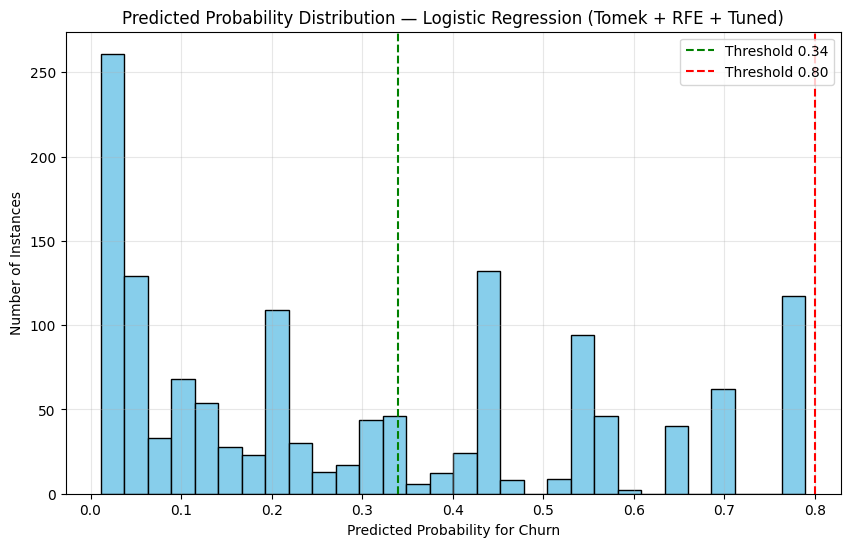

In [46]:
# Get predicted probabilities
proba = model_probs_lr["Logistic Regression (Tomek + RFE + Tuned)"]

plt.figure(figsize=(10, 6))
plt.hist(proba, bins=30, color='skyblue', edgecolor='black')
plt.axvline(0.34, color='green', linestyle='--', label='Threshold 0.34')
plt.axvline(0.80, color='red', linestyle='--', label='Threshold 0.80')

plt.title('Predicted Probability Distribution — Logistic Regression (Tomek + RFE + Tuned)')
plt.xlabel('Predicted Probability for Churn')
plt.ylabel('Number of Instances')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### 10.3 SHAP Explainers for Random Forest Models

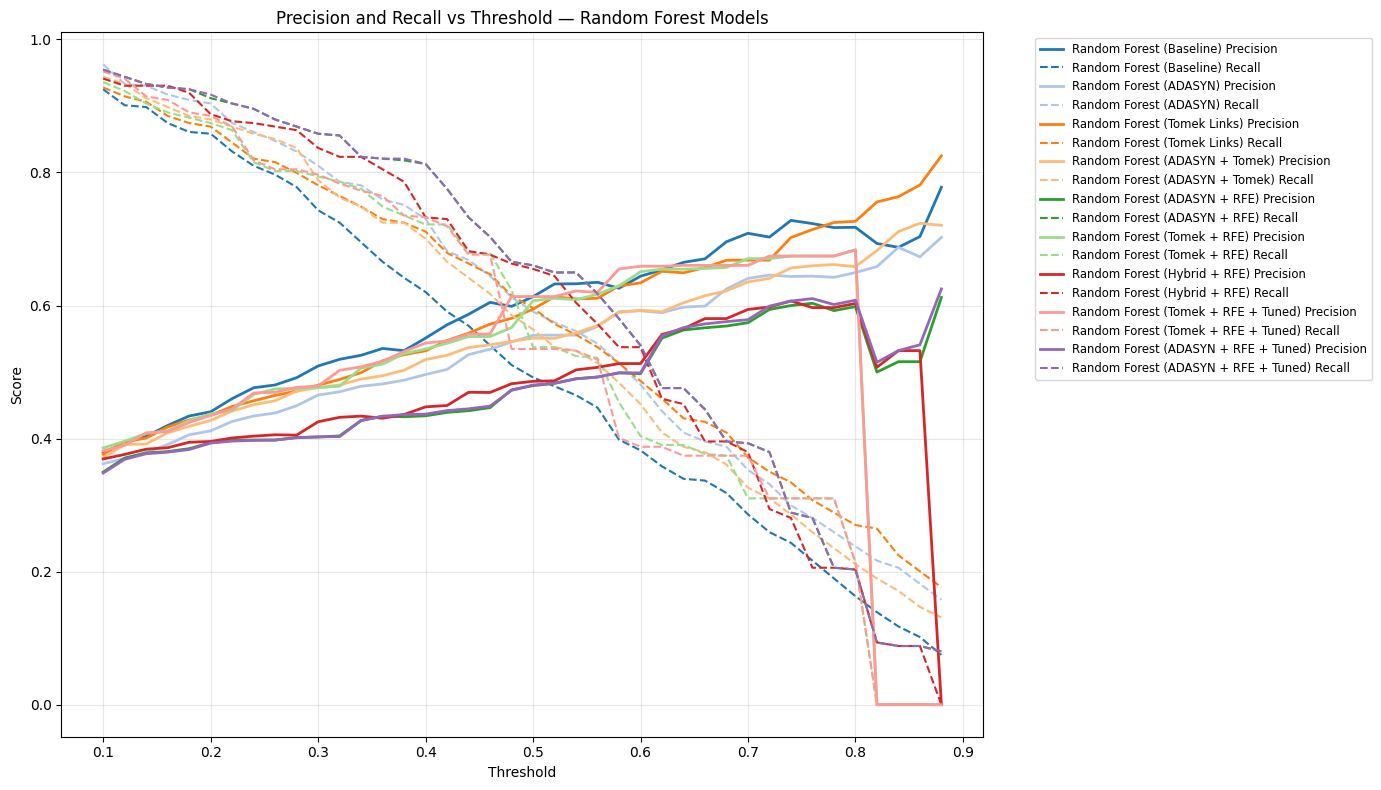

In [47]:
plot_precision_recall_vs_threshold(model_probs_rf, y_test, "Random Forest Models")

In [48]:
thresholds = np.arange(0.1, 0.9, 0.02)
proba = model_probs_rf["Random Forest (Tomek + RFE + Tuned)"]

for t in thresholds:
    preds = (proba >= t).astype(int)
    positives = preds.sum()
    print(f"Threshold {t:.2f}: Predicted Positives = {positives}")

Threshold 0.10: Predicted Positives = 933
Threshold 0.12: Predicted Positives = 903
Threshold 0.14: Predicted Positives = 837
Threshold 0.16: Predicted Positives = 828
Threshold 0.18: Predicted Positives = 785
Threshold 0.20: Predicted Positives = 761
Threshold 0.22: Predicted Positives = 731
Threshold 0.24: Predicted Positives = 653
Threshold 0.26: Predicted Positives = 641
Threshold 0.28: Predicted Positives = 631
Threshold 0.30: Predicted Positives = 622
Threshold 0.32: Predicted Positives = 583
Threshold 0.34: Predicted Positives = 569
Threshold 0.36: Predicted Positives = 554
Threshold 0.38: Predicted Positives = 518
Threshold 0.40: Predicted Positives = 504
Threshold 0.42: Predicted Positives = 492
Threshold 0.44: Predicted Positives = 454
Threshold 0.46: Predicted Positives = 454
Threshold 0.48: Predicted Positives = 326
Threshold 0.50: Predicted Positives = 326
Threshold 0.52: Predicted Positives = 326
Threshold 0.54: Predicted Positives = 320
Threshold 0.56: Predicted Positive

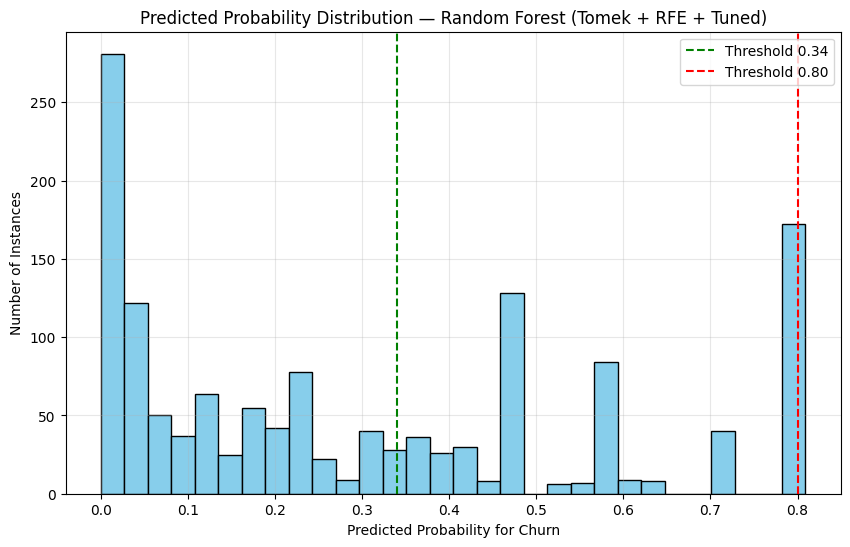

In [49]:
# Get predicted probabilities
proba = model_probs_rf["Random Forest (Tomek + RFE + Tuned)"]

plt.figure(figsize=(10, 6))
plt.hist(proba, bins=30, color='skyblue', edgecolor='black')
plt.axvline(0.34, color='green', linestyle='--', label='Threshold 0.34')
plt.axvline(0.80, color='red', linestyle='--', label='Threshold 0.80')

plt.title('Predicted Probability Distribution — Random Forest (Tomek + RFE + Tuned)')
plt.xlabel('Predicted Probability for Churn')
plt.ylabel('Number of Instances')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [50]:
def plot_roc_curves(model_probs, y_test, title):
    plt.figure(figsize=(14, 8))  # SAME SIZE as Precision-Recall

    colors = plt.get_cmap('tab20').colors
    color_idx = 0

    for model_name, y_proba in model_probs.items():
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        color = colors[color_idx % len(colors)]

        plt.plot(fpr, tpr, color=color, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')

        color_idx += 1

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves — {title}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

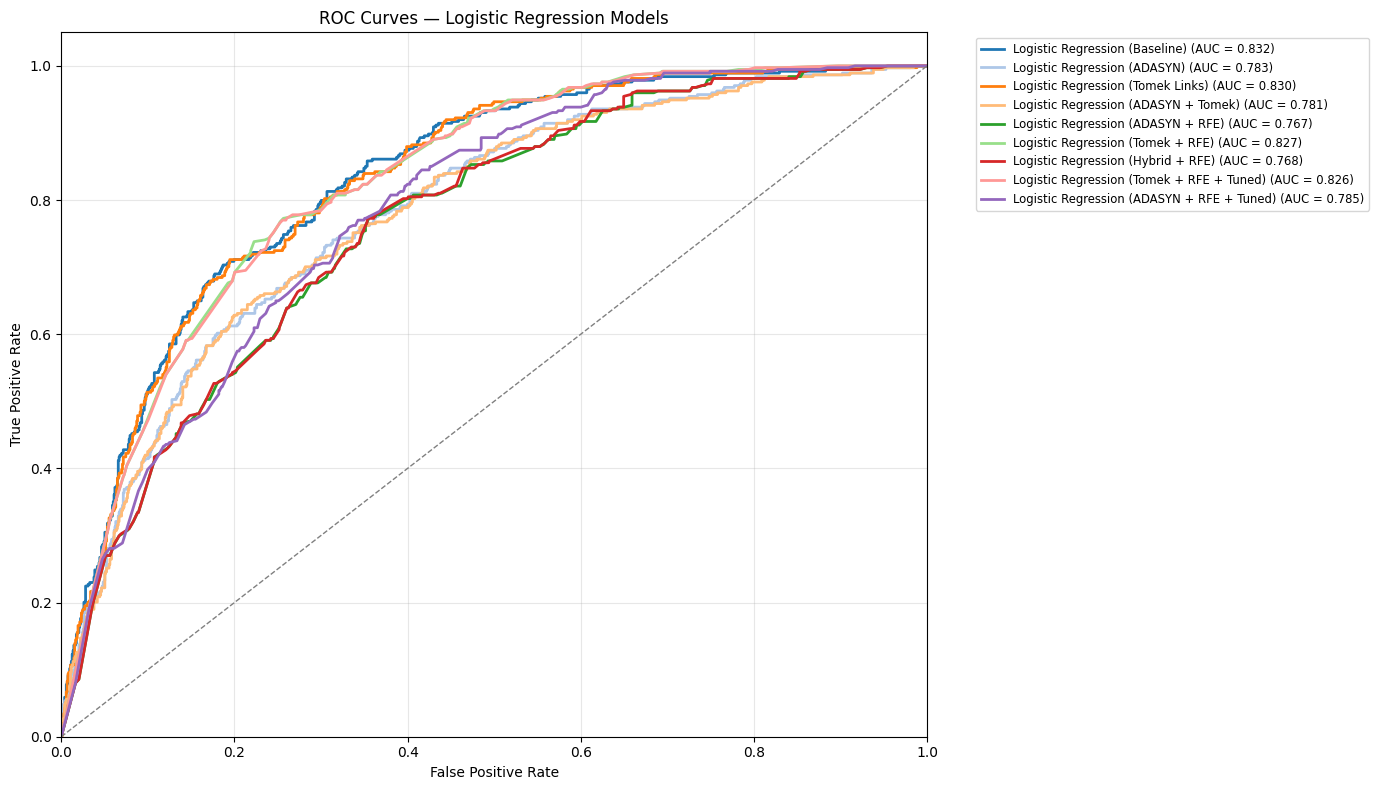

In [51]:
plot_roc_curves(model_probs_lr, y_test, "Logistic Regression Models")

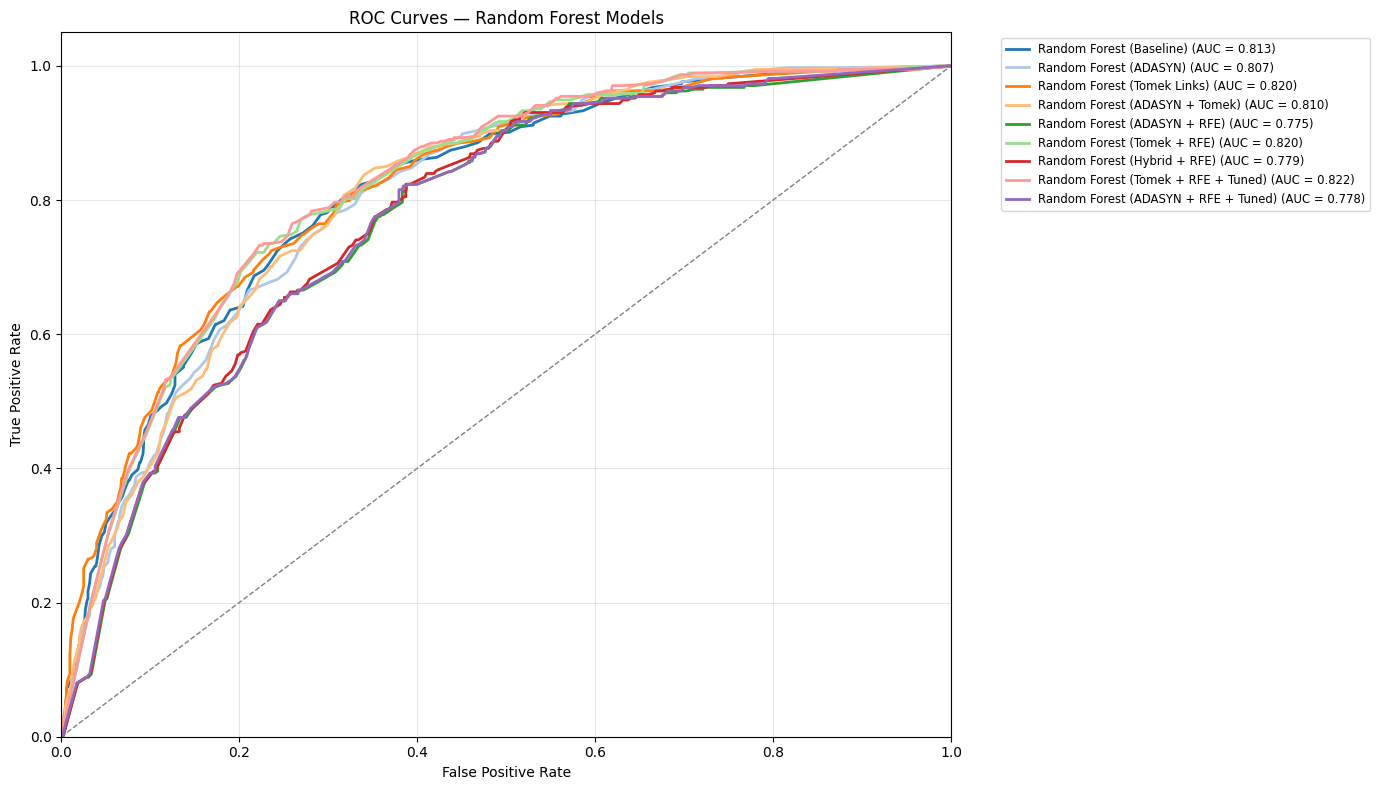

In [52]:
plot_roc_curves(model_probs_rf, y_test, "Random Forest Models")

## 11.0 Callibration Curves

In [53]:
def plot_calibration_curves(model_probs, y_test, title):
    plt.figure(figsize=(14, 8))

    colors = plt.get_cmap('tab20').colors
    color_idx = 0

    for model_name, y_proba in model_probs.items():
        prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)

        color = colors[color_idx % len(colors)]

        plt.plot(prob_pred, prob_true, marker='o', linewidth=2, color=color, label=f'{model_name}')

        color_idx += 1

    plt.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'Calibration Curves — {title}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

### 11.1 Logistic Regression Models

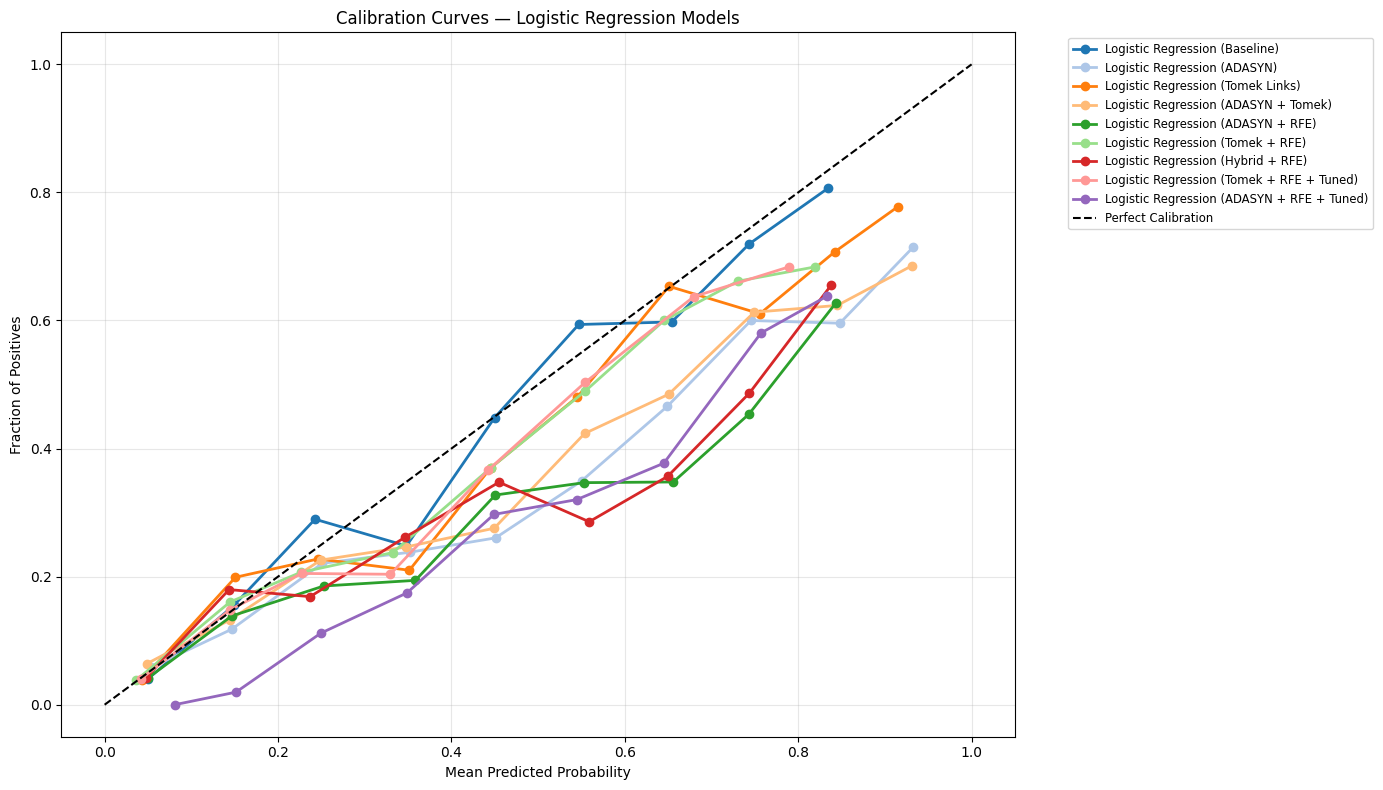

In [54]:
plot_calibration_curves(model_probs_lr, y_test, "Logistic Regression Models")

### 11.2 Random Forest Models

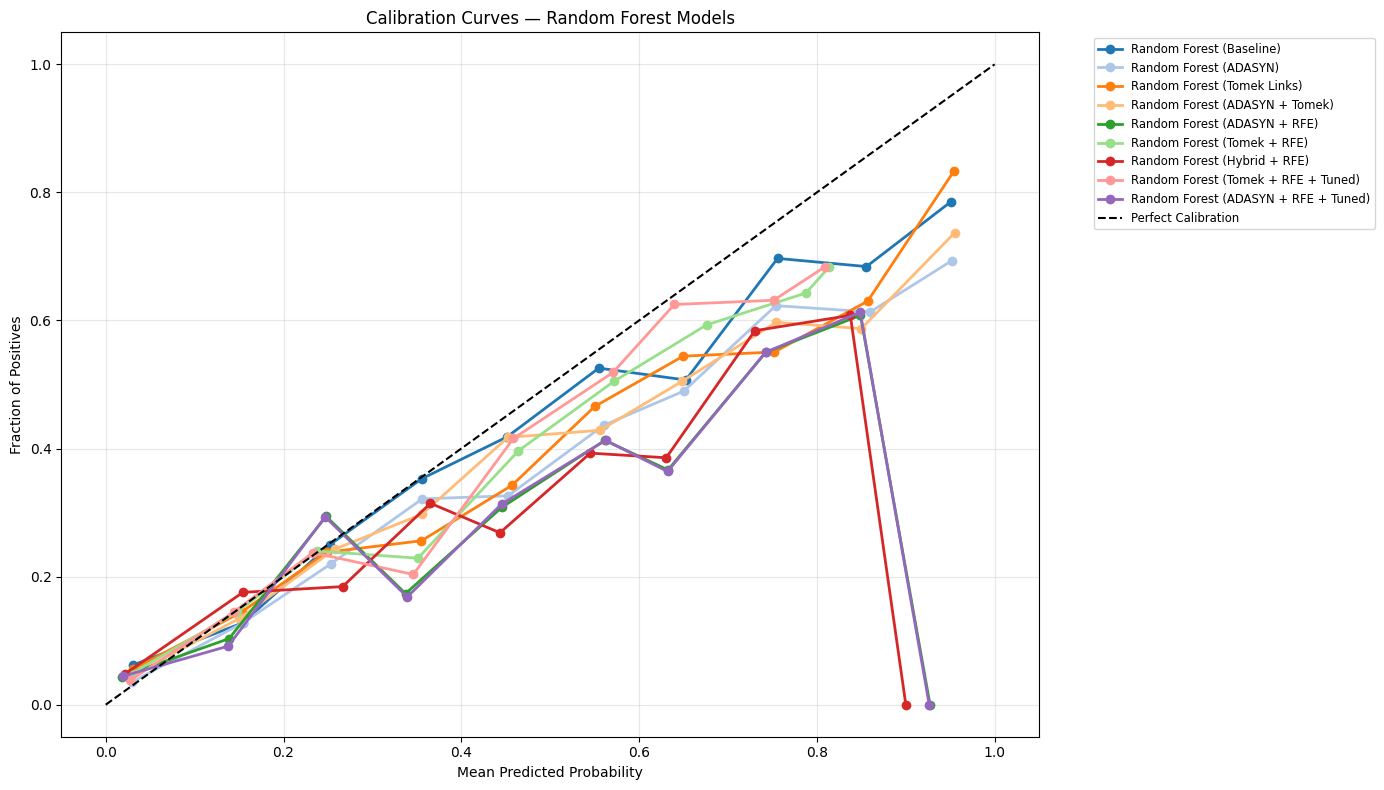

In [55]:
plot_calibration_curves(model_probs_rf, y_test, "Random Forest Models")

## 12.0 Advanced Cost-Sensitive Evaluation

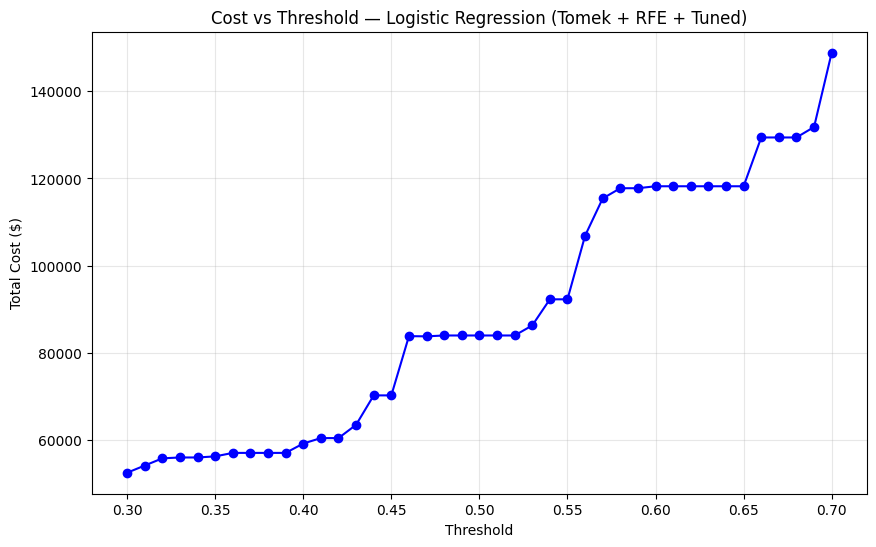

Optimal threshold (min cost): 0.30
Minimum total cost: $52,450.00


In [56]:
# Your existing predicted probabilities
y_proba = model_probs_lr["Logistic Regression (Tomek + RFE + Tuned)"]

# Define threshold range
thresholds = np.arange(0.3, 0.71, 0.01)

# Cost settings
cost_fn = 500  # False Negative cost (missed churner)
cost_fp = 50   # False Positive cost (unnecessary retention)

total_costs = []

for thresh in thresholds:
    y_pred = (y_proba >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    total_cost = (fn * cost_fn) + (fp * cost_fp)
    total_costs.append(total_cost)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, total_costs, marker='o', color='blue')
plt.xlabel('Threshold')
plt.ylabel('Total Cost ($)')
plt.title('Cost vs Threshold — Logistic Regression (Tomek + RFE + Tuned)')
plt.grid(alpha=0.3)
plt.show()

# Display the threshold with minimum cost
min_cost_idx = np.argmin(total_costs)
print(f"Optimal threshold (min cost): {thresholds[min_cost_idx]:.2f}")
print(f"Minimum total cost: ${total_costs[min_cost_idx]:,.2f}")

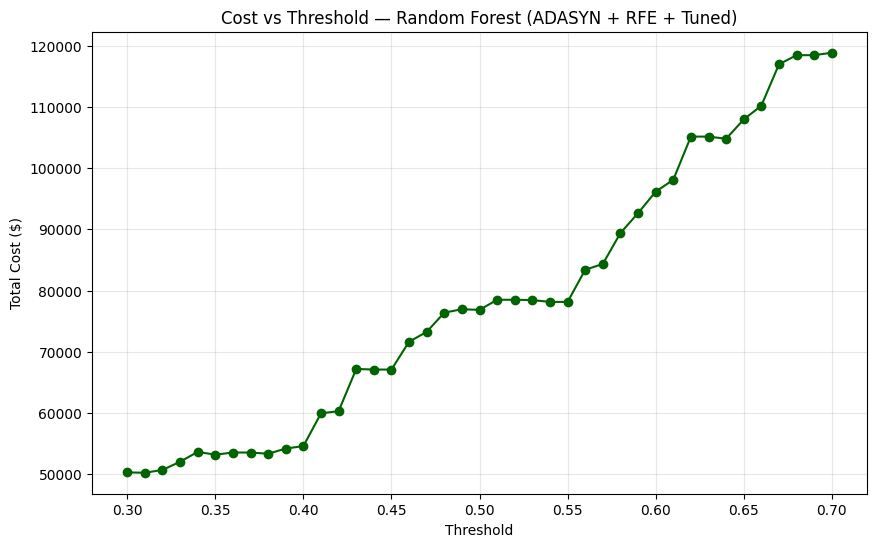

Optimal threshold (min cost): 0.31
Minimum total cost: $50,250.00


In [57]:
# Get the predicted probabilities for Random Forest (ADASYN + RFE + Tuned)
y_proba_rf = model_probs_rf["Random Forest (ADASYN + RFE + Tuned)"]

# Thresholds to evaluate
thresholds = np.arange(0.3, 0.71, 0.01)

# Costs (same as before)
cost_fn = 500  # False Negative
cost_fp = 50   # False Positive

total_costs_rf = []

for thresh in thresholds:
    y_pred_rf = (y_proba_rf >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf).ravel()
    total_cost = (fn * cost_fn) + (fp * cost_fp)
    total_costs_rf.append(total_cost)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, total_costs_rf, marker='o', color='darkgreen')
plt.xlabel('Threshold')
plt.ylabel('Total Cost ($)')
plt.title('Cost vs Threshold — Random Forest (ADASYN + RFE + Tuned)')
plt.grid(alpha=0.3)
plt.show()

# Minimum cost and corresponding threshold
min_cost_idx_rf = np.argmin(total_costs_rf)
print(f"Optimal threshold (min cost): {thresholds[min_cost_idx_rf]:.2f}")
print(f"Minimum total cost: ${total_costs_rf[min_cost_idx_rf]:,.2f}")

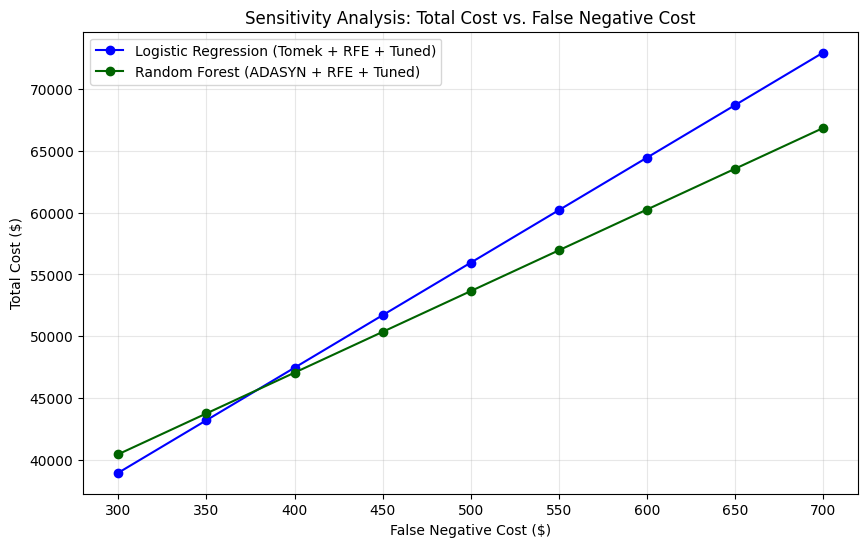

In [58]:
# FN cost range
fn_costs = np.arange(300, 701, 50)  # 300 to 700 in steps of 50
fp_cost = 50

# Best thresholds identified earlier
best_thresh_lr = 0.34
best_thresh_rf = 0.34

# Store total costs for each FN cost
costs_lr = []
costs_rf = []

for fn in fn_costs:
    # Logistic Regression
    y_pred_lr = (model_probs_lr["Logistic Regression (Tomek + RFE + Tuned)"] >= best_thresh_lr).astype(int)
    tn, fp_lr, fn_lr, tp = confusion_matrix(y_test, y_pred_lr).ravel()
    total_cost_lr = (fn_lr * fn) + (fp_lr * fp_cost)
    costs_lr.append(total_cost_lr)

    # Random Forest
    y_pred_rf = (model_probs_rf["Random Forest (ADASYN + RFE + Tuned)"] >= best_thresh_rf).astype(int)
    tn, fp_rf, fn_rf, tp = confusion_matrix(y_test, y_pred_rf).ravel()
    total_cost_rf = (fn_rf * fn) + (fp_rf * fp_cost)
    costs_rf.append(total_cost_rf)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(fn_costs, costs_lr, marker='o', label='Logistic Regression (Tomek + RFE + Tuned)', color='blue')
plt.plot(fn_costs, costs_rf, marker='o', label='Random Forest (ADASYN + RFE + Tuned)', color='darkgreen')
plt.xlabel('False Negative Cost ($)')
plt.ylabel('Total Cost ($)')
plt.title('Sensitivity Analysis: Total Cost vs. False Negative Cost')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 13.0 Feature Importance

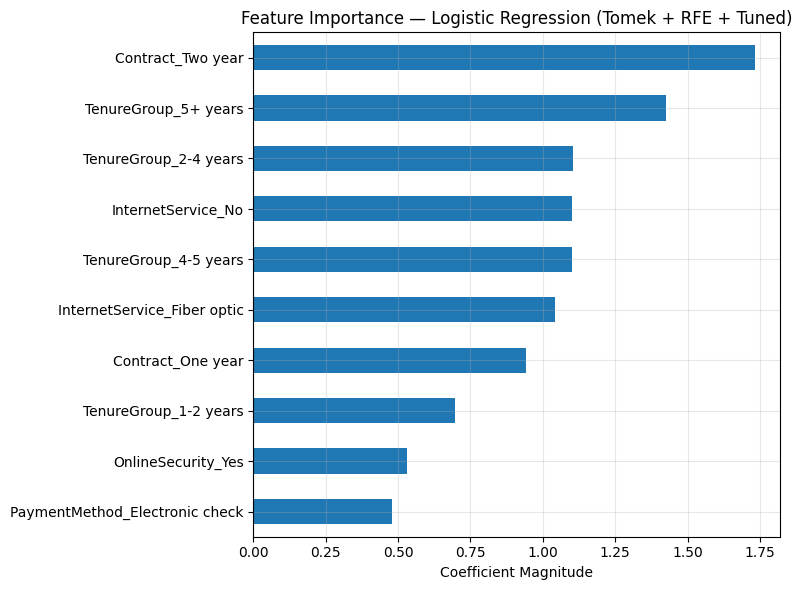

In [59]:
# Get absolute coefficient values
lr_importances = pd.Series(
    abs(lr_tomek.coef_[0]),
    index=X_tomek_rfe.columns
).sort_values(ascending=True)

# Plot
lr_importances.plot(kind='barh', figsize=(8, 6))
plt.title('Feature Importance — Logistic Regression (Tomek + RFE + Tuned)')
plt.xlabel('Coefficient Magnitude')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

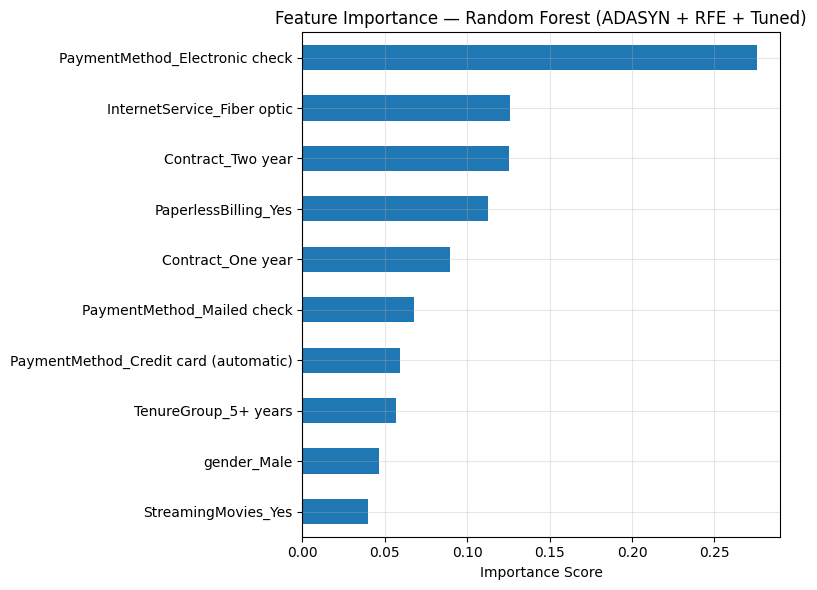

In [60]:
# Get feature importances
rf_importances = pd.Series(
    rf_adasyn.feature_importances_,
    index=X_adasyn_rfe.columns
).sort_values(ascending=True)

# Plot
rf_importances.plot(kind='barh', figsize=(8, 6))
plt.title('Feature Importance — Random Forest (ADASYN + RFE + Tuned)')
plt.xlabel('Importance Score')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 14.0 SHAP

 98%|===================| 2768/2814 [00:47<00:00]        

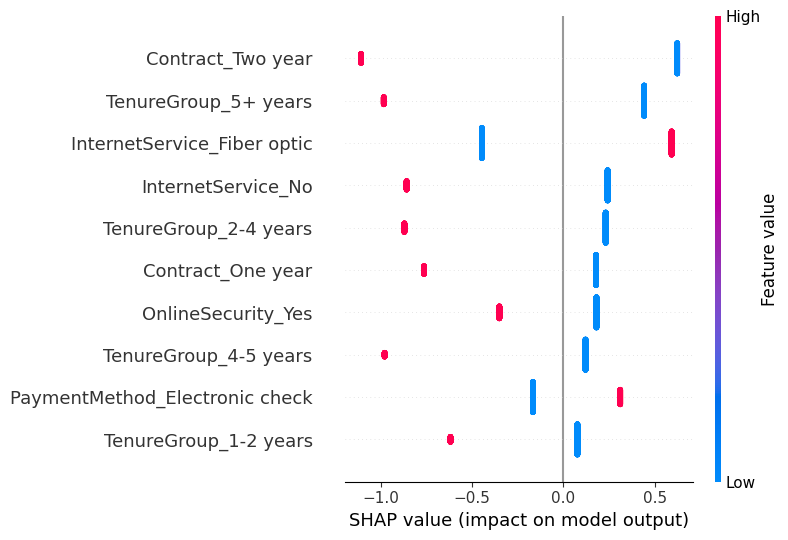

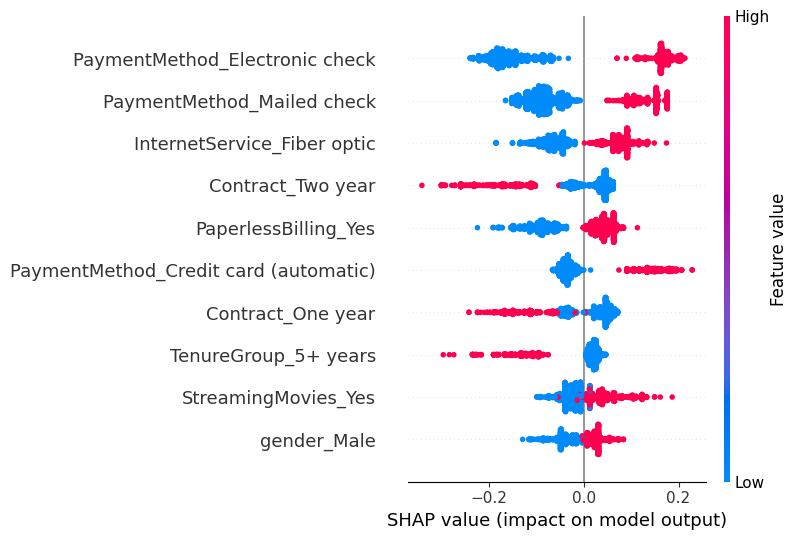

In [61]:
# Sample from the RFE‐subsetted training data, not the full feature set
background_lr = X_tomek_rfe.sample(100, random_state=42)   # 10 columns
background_rf = X_adasyn_rfe.sample(100, random_state=42)  # 10 columns

# Build unified explainers
explainer_lr = shap.Explainer(lr_tomek, background_lr)
explainer_rf = shap.Explainer(rf_adasyn, background_rf)

# Compute SHAP values on your test splits
shap_values_lr = explainer_lr(X_test_tomek)       # Explanation object for LR
shap_values_rf = explainer_rf(X_test_adasyn)      # Explanation object for RF

# Plot summaries
# Logistic Regression (single-output)
shap.summary_plot(
    shap_values_lr.values,
    X_test_tomek,
    feature_names=X_test_tomek.columns,
    title="SHAP — LR (Tomek+RFE+Tuned)"
)

# Random Forest (binary; take the “churn” class at index 1)
shap.summary_plot(
    shap_values_rf.values[:,:,1],
    X_test_adasyn,
    feature_names=X_test_adasyn.columns,
    title="SHAP — RF (ADASYN+RFE+Tuned)"
)

### 14.1 Feature Importance Comparison and Explainability Summary

In [62]:
# Extract LR coefficients and RF importances
lr_coefs = pd.Series(lr_tomek.coef_[0], index=X_test_tomek.columns, name="LR_coef")
rf_imps  = pd.Series(rf_adasyn.feature_importances_, index=X_test_adasyn.columns, name="RF_importance")

# Compute mean(|SHAP|) for each
# LR is single‐output, so shap_values_lr.values is (n_samples, n_features)
lr_shap = pd.Series(
    np.abs(shap_values_lr.values).mean(axis=0),
    index=X_test_tomek.columns,
    name="LR_mean|SHAP|"
)

# RF is binary, we take the SHAP for class 1: shap_values_rf.values[:,:,1]
rf_shap = pd.Series(
    np.abs(shap_values_rf.values[:,:,1]).mean(axis=0),
    index=X_test_adasyn.columns,
    name="RF_mean|SHAP|"
)

# Build two side‐by‐side tables
df_lr = pd.concat([lr_coefs, lr_shap], axis=1).sort_values("LR_coef")
df_rf = pd.concat([rf_imps,  rf_shap ], axis=1).sort_values("RF_importance", ascending=False)

print("=== Logistic Regression (Tomek+RFE+Tuned) ===\n", df_lr)
print("\n=== Random Forest (ADASYN+RFE+Tuned) ===\n", df_rf)

=== Logistic Regression (Tomek+RFE+Tuned) ===
                                  LR_coef  LR_mean|SHAP|
Contract_Two year              -1.732259       0.736339
TenureGroup_5+ years           -1.426712       0.547474
TenureGroup_2-4 years          -1.103077       0.374882
InternetService_No             -1.101239       0.379024
TenureGroup_4-5 years          -1.100607       0.219910
Contract_One year              -0.942793       0.299610
TenureGroup_1-2 years          -0.695235       0.155872
OnlineSecurity_Yes             -0.531973       0.229388
PaymentMethod_Electronic check  0.478992       0.214423
InternetService_Fiber optic     1.040382       0.510823

=== Random Forest (ADASYN+RFE+Tuned) ===
                                        RF_importance  RF_mean|SHAP|
PaymentMethod_Electronic check              0.276041       0.161324
InternetService_Fiber optic                 0.125987       0.069170
Contract_Two year                           0.125513       0.068451
PaperlessBilling_Yes  

## 15.0 Subgroup Performance Evaluation

In [63]:
# Prepare predictions
y_proba_lr = model_probs_lr["Logistic Regression (Tomek + RFE + Tuned)"]
y_pred_lr = (y_proba_lr >= 0.34).astype(int)

# Add gender and SeniorCitizen back to test set
X_test_full_lr = X_test.copy()
X_test_full_lr['gender'] = df.loc[X_test.index, 'gender']
X_test_full_lr['SeniorCitizen'] = df.loc[X_test.index, 'SeniorCitizen']

# Define subgroups using positional indices
groups = {
    'Male': X_test_full_lr.index[X_test_full_lr['gender'] == 'Male'].tolist(),
    'Female': X_test_full_lr.index[X_test_full_lr['gender'] == 'Female'].tolist(),
    'Senior': X_test_full_lr.index[X_test_full_lr['SeniorCitizen'] == 1].tolist(),
    'Non-Senior': X_test_full_lr.index[X_test_full_lr['SeniorCitizen'] == 0].tolist()
}

# Map from original index to positional index
index_to_pos_lr = {idx: pos for pos, idx in enumerate(X_test_full_lr.index)}

# Evaluate metrics by subgroup
for group_name, indices in groups.items():
    pos_indices = [index_to_pos_lr[i] for i in indices]

    y_true_group = y_test.iloc[pos_indices]
    y_pred_group = y_pred_lr[pos_indices]

    precision, recall, f1, support = precision_recall_fscore_support(
        y_true_group, y_pred_group, average='binary', zero_division=0)

    print(f"\nGroup: {group_name}")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall:    {recall:.2f}")
    print(f"  F1 Score:  {f1:.2f}")
    print(f"  Support:   {support}")


Group: Male
  Precision: 0.51
  Recall:    0.78
  F1 Score:  0.62
  Support:   None

Group: Female
  Precision: 0.52
  Recall:    0.76
  F1 Score:  0.62
  Support:   None

Group: Senior
  Precision: 0.55
  Recall:    0.86
  F1 Score:  0.67
  Support:   None

Group: Non-Senior
  Precision: 0.50
  Recall:    0.74
  F1 Score:  0.60
  Support:   None


In [64]:
# Prepare predictions
y_proba_rf = model_probs_rf["Random Forest (ADASYN + RFE + Tuned)"]
y_pred_rf = (y_proba_rf >= 0.35).astype(int)

# Add gender and SeniorCitizen to the test set
X_test_full = X_test.copy()
X_test_full['gender'] = df.loc[X_test.index, 'gender']
X_test_full['SeniorCitizen'] = df.loc[X_test.index, 'SeniorCitizen']

# Define subgroups using **positional indices**
groups = {
    'Male': X_test_full.index[X_test_full['gender'] == 'Male'].tolist(),
    'Female': X_test_full.index[X_test_full['gender'] == 'Female'].tolist(),
    'Senior': X_test_full.index[X_test_full['SeniorCitizen'] == 1].tolist(),
    'Non-Senior': X_test_full.index[X_test_full['SeniorCitizen'] == 0].tolist()
}

# Map from original index to positional index
index_to_pos = {idx: pos for pos, idx in enumerate(X_test_full.index)}

# Evaluate metrics by subgroup
for group_name, indices in groups.items():
    pos_indices = [index_to_pos[i] for i in indices]  # convert to positional

    y_true_group = y_test.iloc[pos_indices]
    y_pred_group = y_pred_rf[pos_indices]

    precision, recall, f1, support = precision_recall_fscore_support(
        y_true_group, y_pred_group, average='binary', zero_division=0)

    print(f"\nGroup: {group_name}")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall:    {recall:.2f}")
    print(f"  F1 Score:  {f1:.2f}")
    print(f"  Support:   {support}")


Group: Male
  Precision: 0.40
  Recall:    0.90
  F1 Score:  0.56
  Support:   None

Group: Female
  Precision: 0.48
  Recall:    0.75
  F1 Score:  0.58
  Support:   None

Group: Senior
  Precision: 0.51
  Recall:    0.91
  F1 Score:  0.66
  Support:   None

Group: Non-Senior
  Precision: 0.41
  Recall:    0.79
  F1 Score:  0.54
  Support:   None
